In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker       = xt.Tracker(line=line[_beam])
        twiss[_beam]  = tracker.twiss().to_pandas(index="name")
        survey[_beam] = tracker.survey().to_pandas(index="name")
    elif _beam == 'b4':
        _tracker      = xt.Tracker(line=line[_beam])
        twiss['b2']   = _tracker.twiss().reverse().to_pandas(index="name")
        survey['b2']  = _tracker.survey().reverse().to_pandas(index="name")


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)


B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)


beam = 'b1'
# Deactivating all wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

    
# Creating BB knobs
#===================================================
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())


for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob 
    for _lr in bb_lr:
        # Infividual knobs
        tracker.vars[f'{_lr}_ON'] = 1
        tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value
        #tracker.element_refs[_lr].n_particles = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].n_particles._value

    for _ho in bb_ho:
        tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value
        #tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

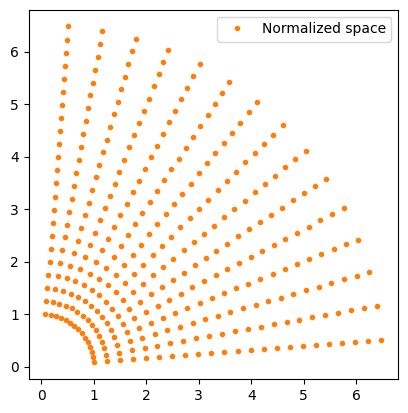

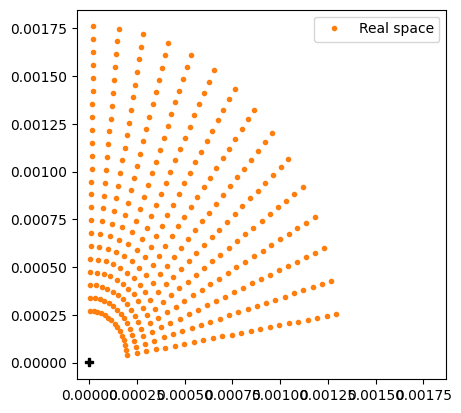

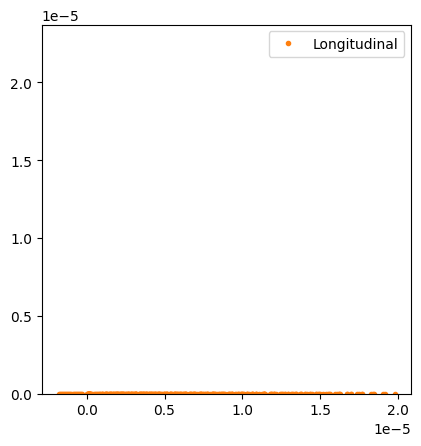

In [2]:


def generate_particles(method='6d'):
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                    emitt     = [B1.emittx,B1.emitty])
    coordinates.insert(0,'delta',0)
    group_length = len(coordinates)

    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( method       = method,
                                    particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles0,coordinates0 = generate_particles()


plt.figure()
plt.plot(coordinates0['x_sig'],coordinates0['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles0.x   ,particles0.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()


plt.figure()
plt.plot(particles0.zeta   ,particles0.delta    ,'.',color='C1',label='Longitudinal')
plt.axis('square')
plt.legend()



---

# Tracking

In [3]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nInitial twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
print(40*'-')


tracker.match(vary=['dqx.b1','dqy.b1'],
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
        
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])





tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================



Initial twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.01114 Q'y = 14.99529
----------------------------------------

Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00040 Q'y = 15.00106


In [4]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked_ref4D = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)




# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1/10
tracker.vars[f'ip5_bbho_ON'] = 1/10

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked4D_HO = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)



# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 1/10
tracker.vars[f'ip5_bblr_ON'] = 1/10

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles(method = '4d')
particles.zeta *= 0
particles.delta *= 0
tracked4D_LR = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)



# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0

#trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
#trackTwiss.set_index('name',inplace=True)





generating ./2d18a4738ab04de4b300f49454cf170e.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '2d18a4738ab04de4b300f49454cf170e' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 2d18a4738ab04de4b300f49454cf170e.c -o ./2d18a4738ab04de4b300f49454cf170e.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

generating ./cd66e9730e1a4a4e99ca5b3ce9a45d80.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building 'cd66e9730e1a4a4e99ca5b3ce9a45d80' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c cd66e9730e1a4a4e99ca5b3ce9a45d80.c -o ./cd66e9730e1a4a4e99ca5b3ce9a45d80.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./cd66e9730e1a4a4e99ca5b3ce9a45d80.o -o ./cd66e9730e1a4a4e99ca5b3ce9a45d80.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


generating ./daf223c8d60c4c93bf60145e70da1fb5.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building 'daf223c8d60c4c93bf60145e70da1fb5' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c daf223c8d60c4c93bf60145e70da1fb5.c -o ./daf223c8d60c4c93bf60145e70da1fb5.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

generating ./334873bb1553456f93e16dca1e40ab6c.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '334873bb1553456f93e16dca1e40ab6c' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 334873bb1553456f93e16dca1e40ab6c.c -o ./334873bb1553456f93e16dca1e40ab6c.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/mi

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


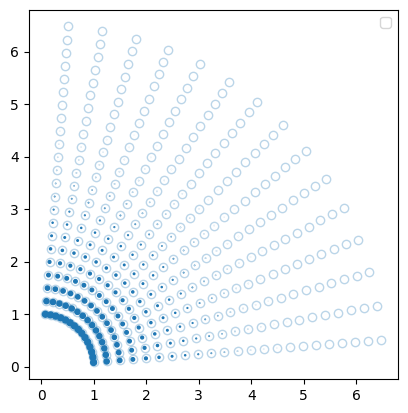

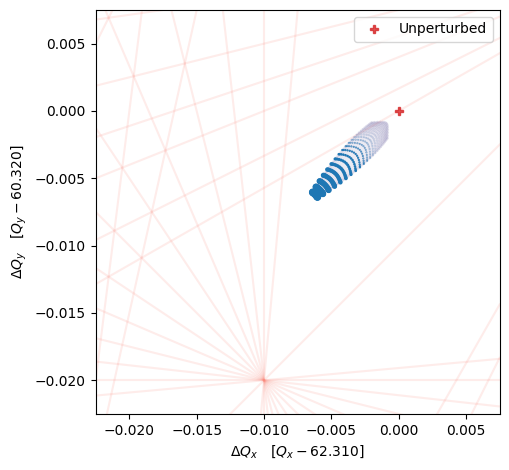

In [5]:
import scipy.stats as sciStat


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
plt.legend()
#plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting

plt.figure()

#---------------
tracked4D_HO._tunesMTD     = 'pynaff'
tracked_ref4D._tunesMTD = 'pynaff'
dQx = tracked4D_HO.tunes_n['Qx'] - tracked_ref4D.tunes_n['Qx']
dQy = tracked4D_HO.tunes_n['Qy'] - tracked_ref4D.tunes_n['Qy']

# Scale for scale_strength factor
dQx *= 10
dQy *= 10
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(dQx,dQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_HO_4D.png',format='png',dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


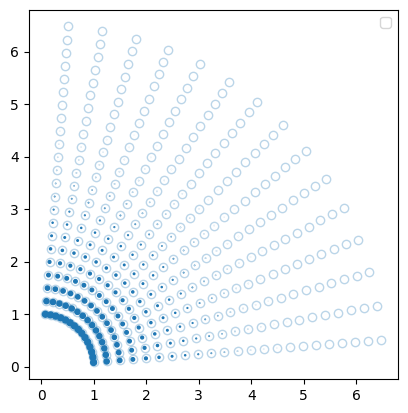

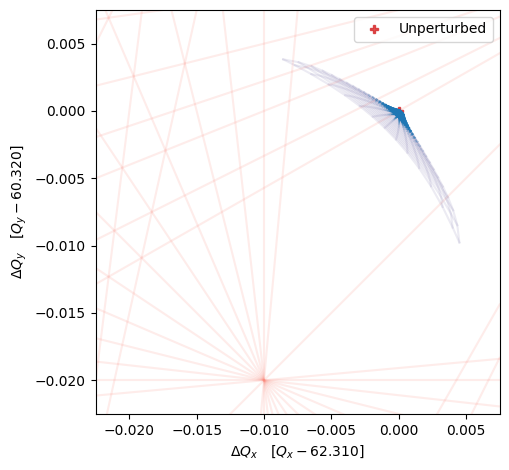

In [6]:
import scipy.stats as sciStat


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
plt.legend()
#plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting

plt.figure()

#---------------
tracked4D_LR._tunesMTD     = 'pynaff'
tracked_ref4D._tunesMTD = 'pynaff'
dQx = tracked4D_LR.tunes_n['Qx'] - tracked_ref4D.tunes_n['Qx']
dQy = tracked4D_LR.tunes_n['Qy'] - tracked_ref4D.tunes_n['Qy']

# Scale for scale_strength factor
dQx *= 10
dQy *= 10
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(dQx,dQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_LR_4D.png',format='png',dpi=300)


In [7]:
if True:
    OUTFOLDER = 'VS_4D_Analytic'
    tracked4D_HO.to_pickle(f'{OUTFOLDER}/ tracked4D_HO_sf10.pkl')
    tracked4D_LR.to_pickle(f'{OUTFOLDER}/ tracked4D_LR_sf10.pkl')
    # tracked4D.to_pickle(f'{OUTFOLDER}/tracked4D.pkl')
    # tracked_ref4D.to_pickle(f'{OUTFOLDER}/tracked_ref4D.pkl')
    # coordinates.to_pickle(f'{OUTFOLDER}/coordinates.pkl')